In [1]:
%%javascript
/**********************************************************************************************
Known Mathjax Issue with Chrome - a rounding issue adds a border to the right of mathjax markup
https://github.com/mathjax/MathJax/issues/1300
A quick hack to fix this based on stackoverflow discussions: 
http://stackoverflow.com/questions/34277967/chrome-rendering-mathjax-equations-with-a-trailing-vertical-line
**********************************************************************************************/

$('.math>span').css("border-left-color","transparent")

<IPython.core.display.Javascript object>

In [ ]:
%reload_ext autoreload
%autoreload 2

# DATASCI W261 - Machine Learning At Scale
## Assignment - Week 09
---

* **Name:**  Megan Jasek
* **Email:**  meganjasek@ischool.berkeley.edu
* **Class Name:**  W261-2
* **Date:**  7/17/16

---
### Instructions

Due by 07/17/2016

[Submission Link - Google Form](https://docs.google.com/forms/d/1ZOr9RnIe_A06AcZDB6K1mJN4vrLeSmS2PD6Xm3eOiis/viewform?usp=send_form) 

### Documents:
* IPython Notebook, published and viewable online.
* PDF export of IPython Notebook.
    
### Useful References

* Data-intensive text processing with MapReduce. San Rafael, CA: Morgan & Claypool Publishers. Chapter 5. 


---

<h2 style="color:darkblue">HW 9 Dataset</h2>

Note that all referenced files life in the enclosing directory. [Checkout the Data subdirectory on Dropbox](https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0) or the AWS S3 buckets (details contained each question). 

<h2 style="color:darkblue"> HW 9.0: Short answer questions </h2>

__ What is PageRank and what is it used for in the context of web search?__



<hr>

__ What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to compute the Steady State Distibution? __



<hr>

__ OPTIONAL: In topic-specific pagerank, how can we ensure that the irreducible property is satifsied? (HINT: see HW9.4) __



<hr>


<h2 style="color:darkblue"> HW 9.1: MRJob implementation of basic PageRank </h2>

Write a basic MRJob implementation of the iterative PageRank algorithm that takes sparse adjacency lists as input (as explored in HW 7).

Make sure that you implementation utilizes teleportation (1-damping/the number of nodes in the network), and further, distributes the mass of dangling nodes with each iteration so that the output of each iteration is correctly normalized (sums to 1).


[NOTE: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page, chooses the next page to which it will move by clicking at random, with probability d,one of the hyperlinks in the current page. This probability is represented by a so-called *damping factor* d, where d ∈ (0, 1). Otherwise, with probability (1 − d), the surfer jumps to any web page in the network. If a page is a dangling end, meaning it has no outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform distribution and “teleports” to that page]


As you build your code, use the test data:

> s3://ucb-mids-mls-networks/PageRank-test.txt

Or under the Data Subfolder for HW7 on Dropbox with the same file name. 
> Dropbox: https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0

with teleportation parameter set to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck your work with the true result, displayed in the first image in the [Wikipedia article](https://en.wikipedia.org/wiki/PageRank)
and here for reference are the corresponding PageRank probabilities:
<pre>

A, 0.033
B, 0.384
C, 0.343
D, 0.039
E, 0.081
F, 0.039
G, 0.016
H, 0.016
I, 0.016
J, 0.016
K, 0.016

</pre>

<h2 style="color:darkgreen"> HW 9.1 Implementation </h2>

### Create test file:  PageRank-test.txt

In [3]:
%%writefile PageRank-test.txt
B	{'C': 1}
C	{'B': 1}
D	{'A': 1, 'B': 1}
E	{'D': 1, 'B': 1, 'F': 1}
F	{'B': 1, 'E': 1}
G	{'B': 1, 'E': 1}
H	{'B': 1, 'E': 1}
I	{'B': 1, 'E': 1}
J	{'E': 1}
K	{'E': 1}

Writing PageRank-test.txt


### Expected Output from PageRank-test.txt

https://en.wikipedia.org/wiki/PageRank

and here for reference are the corresponding PageRank probabilities:

A, 0.033  
B, 0.384  
C, 0.343  
D, 0.039  
E, 0.081  
F, 0.039  
G, 0.016  
H, 0.016  
I, 0.016  
J, 0.016  
K, 0.016  

0.999 = 0.033+0.384+0.343+0.039+0.081+0.039+0.016+0.016+0.016+0.016+0.016

### Create test file:  Lecture9_10_test.txt

In [2]:
%%writefile Lecture9_10_test.txt
N1	{'N2': 1, 'N4': 1}
N2	{'N3': 1, 'N5': 1}
N3	{'N4': 1}
N4	{'N5': 1}
N5	{'N1': 1, 'N2': 1, 'N3': 1}

Writing Lecture9_10_test.txt


### Expected Output from Lecture9_10_test.txt

Iteration 10  
N1 [{u'N2': 1, u'N4': 1}, 0.10593707133058988]  
N2 [{u'N3': 1, u'N5': 1}, 0.1575895919067216]  
N3 [{u'N4': 1}, 0.18432891803840884]  
N4 [{u'N5': 1}, 0.23511445473251036]  
N5 [{u'N1': 1, u'N2': 1, u'N3': 1}, 0.31702996399176964]  
Total Error:  0.00860982510288  

### Create test file:  Lecture9_10d_test.txt

In [46]:
%%writefile Lecture9_10d_test.txt
N1	{'N2': 1, 'N4': 1}
N2	{'N3': 1, 'N5': 1}
N3	{'N4': 1}
N4	{'N5': 1, 'N6': 1}
N5	{'N1': 1, 'N2': 1, 'N3': 1}

Writing Lecture9_10d_test.txt


In [6]:
%%writefile PageRankInit.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import ast
import json

# This class takes an adjacency list as input and outputs and initialized work file with 
# the following format:
# node_number \t [adjacency_list, infinity, '', 'U']
# One starting node is defined as an argument passed in to the class.  The default is node '1'.
# That starting node has the format:
# node_number \t [adjacency_list, 0.0, '', 'Q']
# U means Unvisited
# Q means Queued in the queue
class MRPageRankInit(MRJob):
    def configure_options(self):
        # Configure a new command line option to capture the stop_index for the shortest path
        super(MRPageRankInit, self).configure_options()
        self.add_passthrough_option('--platform', type='str', default='hadoop')

    def __init__(self, *args, **kwargs):
        super(MRPageRankInit, self).__init__(*args, **kwargs)
        self.total_nodes_calculated = False
        self.total_nodes = 0

    # For the node equal to the start index, yield
    #    node_number \t tuple(adj_list, 0.0, "", 'Q')
    # For all other nodes, yield
    #    node_number \t tuple(adj_list, infinity, "", 'U')    
    def mapper(self, _, line):
        node_num, adj_dict = line.strip().split('\t')
        adj_dict = ast.literal_eval(adj_dict)
        self.total_nodes += 1
        yield node_num, tuple((adj_dict, 1.0))
        yield '*' + node_num, 1
        for node in adj_dict:
            yield node, tuple(({}, 1.0))
            yield '*' + node, 1

    def reducer(self, node_num, data):
        if node_num[0] == '*':
            self.total_nodes += 1
        else:
            if self.total_nodes_calculated == False:
                yield '*total_nodes', self.total_nodes
                self.total_nodes_calculated = True
            f_adj_dict = {}
            for adj_dict, value in data:
                if adj_dict != {} and f_adj_dict == {}:
                    f_adj_dict = adj_dict
            #print node_num, tuple((f_adj_dict, 1.0/self.total_nodes))
            yield node_num, tuple((f_adj_dict, 1.0/self.total_nodes))
        
    # Create the steps for the MRJob.  There is only a mapper in this job.
    # Run with 1 reducer when not running in Hadoop
    def steps(self):
        JOBCONF_STEP_LOCAL = {
            'mapreduce.job.reduces': '1'
        }
        if self.options.platform == 'local':
            JOBCONF_STEP = JOBCONF_STEP_LOCAL
        else:
            JOBCONF_STEP = {}
        return [
            MRStep(jobconf=JOBCONF_STEP,
                   mapper=self.mapper,
                   reducer=self.reducer)
               ]
            
if __name__ == '__main__':
    MRPageRankInit.run()

Overwriting PageRankInit.py


In [71]:
#!python PageRankInit.py Lecture9_10_test.txt '--platform=local'
#!python PageRankInit.py PageRank-test.txt '--platform=local'
!python PageRankInit.py Lecture9_10d_test.txt '--platform=local'

No configs found; falling back on auto-configuration
Creating temp directory /tmp/PageRankInit.hadoop.20160714.065856.164552
Running step 1 of 1...
N1 ({u'N2': 1, u'N4': 1}, 0.16666666666666666)
N2 ({u'N3': 1, u'N5': 1}, 0.16666666666666666)
N3 ({u'N4': 1}, 0.16666666666666666)
N4 ({u'N5': 1, u'N6': 1}, 0.16666666666666666)
N5 ({u'N1': 1, u'N2': 1, u'N3': 1}, 0.16666666666666666)
N6 ({}, 0.16666666666666666)
Streaming final output from /tmp/PageRankInit.hadoop.20160714.065856.164552/output...
"*total_nodes"	6
"N1"	[{"N2": 1, "N4": 1}, 0.16666666666666666]
"N2"	[{"N3": 1, "N5": 1}, 0.16666666666666666]
"N3"	[{"N4": 1}, 0.16666666666666666]
"N4"	[{"N5": 1, "N6": 1}, 0.16666666666666666]
"N5"	[{"N1": 1, "N2": 1, "N3": 1}, 0.16666666666666666]
"N6"	[{}, 0.16666666666666666]
Removing temp directory /tmp/PageRankInit.hadoop.20160714.065856.164552...


In [1]:
%%writefile PageRankStep1.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import json

class MRPageRankStep1(MRJob):
    def configure_options(self):
        # Configure a new command line option to capture the stop_index for the shortest path
        super(MRPageRankStep1, self).configure_options()
        self.add_passthrough_option('--num_converter', type='int', default=1)

    def __init__(self, *args, **kwargs):
        super(MRPageRankStep1, self).__init__(*args, **kwargs)
        self.total_page_rank_dangling = 0.0
    
    def mapper(self, key, line):
        node_num, data = line.strip().split('\t')
        node_num = node_num.strip('"')
        #print node_num, data
        if node_num != '*total_nodes':
            data = json.loads(data)
            adj_dict = data[0]
            degree = float(len(adj_dict))
            page_rank = data[1]
            # If the node is a dangling node, then add its page rank to the dangling mass count
            if adj_dict == {}:
                self.total_page_rank_dangling += page_rank
            # Yield the node to preserve the graph structure
            yield node_num, tuple((adj_dict, 0.0))
            for node, value in adj_dict.iteritems():
                yield node, tuple(({}, page_rank/degree))
    
    def mapper_final(self):
        #print self.options.num_converter
        yield '*total_dangling', tuple(({}, self.total_page_rank_dangling))
    
    def reducer(self, node, data):
        #print node
        #yield node, None
        if node == '*total_dangling':
            for adj_dict, value in data:
                self.total_page_rank_dangling += float(value)
            #print 'dm: ', self.total_page_rank_dangling
            self.increment_counter('PageRank_Counters', 'Dangling_Mass', 
                                   int(self.options.num_converter*self.total_page_rank_dangling))
        else:
            f_adj_dict = {}
            f_page_rank = 0.0
            for adj_dict, page_rank in data:
                if adj_dict != {} and f_adj_dict == {}:
                    f_adj_dict = adj_dict
                f_page_rank += float(page_rank)
            yield node, tuple((f_adj_dict, f_page_rank))

    def steps(self):
        JOBCONF_STEP = {        
            'mapreduce.job.reduces': '10'
        }
        return [
            MRStep(jobconf=JOBCONF_STEP,
                   mapper=self.mapper, mapper_final=self.mapper_final,
                   reducer=self.reducer)
               ]
            
if __name__ == '__main__':
    MRPageRankStep1.run()

Overwriting PageRankStep1.py


### Test PageRankStep1 locally and in HDFS

In [2]:
iterations = 1
total_nodes = 11.0
#total_nodes = 15192277.0

# Set the damping factor
damping_factor = 0.85
num_converter = 10000000000
#!hdfs dfs -rm -r /user/hadoop/HW9Output/PageRank1
#!hdfs dfs -rm -r /user/hadoop/HW9Input/PageRank1
#!hdfs dfs -cp /user/hadoop/HW9Results/PageRankInit_test /user/hadoop/HW9Input/PageRank1
#!hdfs dfs -copyToLocal /user/hadoop/HW9Input/PageRank1/part-00000 pagerank1_test.txt
#!python PageRankInit.py Lecture9_10d_test.txt '--platform=local'
!python PageRankStep1.py pagerank1_test.txt '--num_converter=10000000000'
#!python PageRankStep1.py hdfs:///user/hadoop/HW9Input/PageRank1 -r hadoop '--num_converter=10000000000'

No configs found; falling back on auto-configuration
Creating temp directory /tmp/PageRankStep1.hadoop.20160716.052020.268331
Running step 1 of 1...
Counters: 1
	PageRank_Counters
		Dangling_Mass=909090909
Streaming final output from /tmp/PageRankStep1.hadoop.20160716.052020.268331/output...
"B"	[{"C": 1}, 0.3484848484848485]
"C"	[{"B": 1}, 0.09090909090909091]
"D"	[{"A": 1, "B": 1}, 0.030303030303030304]
"E"	[{"B": 1, "D": 1, "F": 1}, 0.36363636363636365]
"A"	[{}, 0.045454545454545456]
"H"	[{"B": 1, "E": 1}, 0.0]
"I"	[{"B": 1, "E": 1}, 0.0]
"J"	[{"E": 1}, 0.0]
"K"	[{"E": 1}, 0.0]
"F"	[{"B": 1, "E": 1}, 0.030303030303030304]
"G"	[{"B": 1, "E": 1}, 0.0]
Removing temp directory /tmp/PageRankStep1.hadoop.20160716.052020.268331...


In [8]:
%%writefile PageRankStep2.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import json

class MRPageRankStep2(MRJob):
    def configure_options(self):
        # Configure a new command line option to capture the stop_index for the shortest path
        super(MRPageRankStep2, self).configure_options()
        self.add_passthrough_option('--damping_factor', type='float', default=0.15)
        self.add_passthrough_option('--total_nodes', type='float', default=1.0)
        self.add_passthrough_option('--dangling_mass', type='float', default=0.0)

    def mapper(self, key, line):
        node_num, data = line.strip().split('\t')
        node_num = node_num.strip('"')
        #print node_num, data
        if node_num != '*total_nodes':
            data = json.loads(data)
            adj_dict = data[0]
            page_rank = data[1]
            f_page_rank = (1-self.options.damping_factor)*(1.0/self.options.total_nodes)+ \
                self.options.damping_factor*((self.options.dangling_mass/self.options.total_nodes)+page_rank)
            #print node_num, tuple((adj_dict, f_page_rank))                    
            yield node_num, tuple((adj_dict, f_page_rank))

    def steps(self):
        return [
            MRStep(mapper=self.mapper)
               ]
            
if __name__ == '__main__':
    MRPageRankStep2.run()

Overwriting PageRankStep2.py


In [9]:
import PageRankStep1
import PageRankStep2
import PageRankInit
reload(PageRankStep1)
reload(PageRankStep2)
reload(PageRankInit)
import json

# Set the damping factor
damping_factor = 0.85
#damping_factor = 1.0
epsilon = 0.01
iterations = 30
num_converter = 10000000000

# Set the name of the file that gets passed from iteration to iteration
work_filename = 'work_table.txt'

# Initialize a list ot store the page_ranks from iteration to iteration
page_ranks = []
# Call the PageRankInit MRJob
#mr_job = PageRankInit.MRPageRankInit(args=['Lecture9_10_test.txt', '--platform', 'local'])
#mr_job = PageRankInit.MRPageRankInit(args=['Lecture9_10d_test.txt', '--platform', 'local'])
mr_job = PageRankInit.MRPageRankInit(args=['PageRank-test.txt', '--platform', 'local'])
with mr_job.make_runner() as runner, open(work_filename, 'w') as f: 
    runner.run()
    # stream_output: get access of the output 
    for line in runner.stream_output():
        key, value =  mr_job.parse_output_line(line)
        # Store the total_nodes
        if key == '*total_nodes':
            total_nodes = float(value)
        else:
            page_ranks.append(value[1])
        f.write(key+'\t'+json.dumps(value)+'\n')

work_filename_1 = 'work_table_1.txt'
work_filename_2 = 'work_table_2.txt'
i = 0
while(i < iterations):
    # Run the PageRankStep1 MRJob
    mr_job = PageRankStep1.MRPageRankStep1(args=[work_filename, '--num_converter', str(num_converter)])
    with mr_job.make_runner() as runner, open(work_filename_1, 'w') as f: 
        runner.run()
        # stream_output: get access of the output 
        for line in runner.stream_output():
            key, value =  mr_job.parse_output_line(line)
            f.write(key+'\t'+json.dumps(value)+'\n')
    dangling_mass = runner.counters()[0]['PageRank_Counters']['Dangling_Mass']/float(num_converter)
    print 'dm', dangling_mass

    # Run the PageRankStep2 MRJob
    mr_job = PageRankStep2.MRPageRankStep2(args=[work_filename_1, '--damping_factor', damping_factor, '--total_nodes',
                                                total_nodes, '--dangling_mass', dangling_mass])
    with mr_job.make_runner() as runner, open(work_filename_2, 'w') as f: 
        runner.run()
        # stream_output: get access of the output 
        for line in runner.stream_output():
            key, value =  mr_job.parse_output_line(line)
            f.write(key+'\t'+json.dumps(value)+'\n')

    !mv $work_filename_2 $work_filename
    i += 1

A ({}, 0.09090909090909091)
B ({u'C': 1}, 0.09090909090909091)
C ({u'B': 1}, 0.09090909090909091)
D ({u'A': 1, u'B': 1}, 0.09090909090909091)
E ({u'B': 1, u'D': 1, u'F': 1}, 0.09090909090909091)
F ({u'B': 1, u'E': 1}, 0.09090909090909091)
G ({u'B': 1, u'E': 1}, 0.09090909090909091)
H ({u'B': 1, u'E': 1}, 0.09090909090909091)
I ({u'B': 1, u'E': 1}, 0.09090909090909091)
J ({u'E': 1}, 0.09090909090909091)
K ({u'E': 1}, 0.09090909090909091)
dm 0.0909090909
dm 0.0592975206
dm 0.0379464062
dm 0.0640190695
dm 0.0375959647
dm 0.0386749363
dm 0.0341177257
dm 0.0346526855
dm 0.0332641479
dm 0.0332687067
dm 0.0329301017
dm 0.0329194443
dm 0.0328282893
dm 0.0328197384
dm 0.0327957341
dm 0.0327922737
dm 0.0327858041
dm 0.0327845371
dm 0.0327827832
dm 0.0327823577
dm 0.032781877
dm 0.0327817395
dm 0.0327816067
dm 0.0327815636
dm 0.0327815266
dm 0.0327815133
dm 0.0327815029
dm 0.0327814989
dm 0.032781496
dm 0.0327814948


## HW9.2

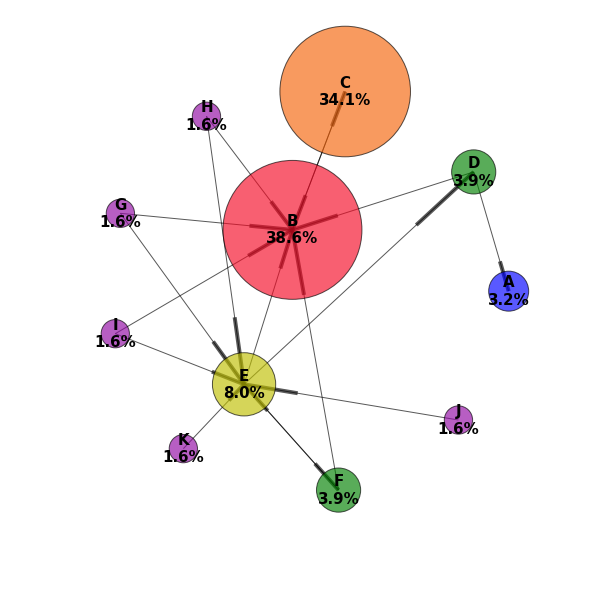

In [48]:
%matplotlib inline

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import json
from operator import itemgetter

G = nx.DiGraph()
node_labels = {}
l = []
with open('pagerank_test_25iter.txt', 'r') as f:
    for line in f.readlines():
        node_num, data = line.strip().split('\t')
        node_num = node_num.strip('"')
        data = json.loads(data)
        adj_dict = data[0]
        page_rank = int(data[1]*1000)/10.0
        G.add_node(node_num, pr=page_rank)
        l.append([node_num, page_rank])
        for node in adj_dict:
            G.add_edges_from([(node_num, str(node))])  

colors = ['#F50A25', '#F5640A', 'y', 'g', 'b', '#9108A3', 'c', 'm', 'w', '#F748C0', '#999B9E']
l = sorted(l, key=itemgetter(1), reverse=True)
cur_pr = -1.0
cur_color = -1
node_colors_dict = {}
for item in l:
    if item[1] == cur_pr:
        node_colors_dict[item[0]] = colors[cur_color]
    else:
        cur_color += 1
        cur_pr = item[1]
        node_colors_dict[item[0]] = colors[cur_color]

node_sizes = []
node_labels = {}
node_colors = []
for node in G.nodes(data=True):
    node_name = node[0]
    node_data = node[1]
    node_sizes.append(node_data['pr']*500)
    node_labels[node_name] = node_name+'\n'+str(node_data['pr'])+'%'
    node_colors.append(node_colors_dict[node_name])

plt.figure(figsize=(10,10))
pos=nx.spring_layout(G, k=0.55, iterations=40)
#pos=nx.circular_layout(G,scale=5)
#nx.draw_networkx_labels(G,pos,node_labels,font_size=13,font_weight='bold')
nx.draw_networkx_labels(G,pos,node_labels,font_size=15,font_weight='bold')
nx.draw(G,pos, node_color=node_colors, node_size=node_sizes, alpha=0.65)
plt.show()

In [1]:
#### Create HDFS directories
#!hdfs dfs -mkdir /user/hadoop/HW9Output
#!hdfs dfs -mkdir /user/hadoop/HW9Input
#!hdfs dfs -mkdir /user/hadoop/HW9Results
#!hdfs dfs -mkdir /user/hadoop/HW9Data
#!hdfs dfs -copyFromLocal PageRank-test.txt /user/hadoop/HW9Data

16/07/14 14:06:10 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Test PageRankInit with HDFS

In [26]:
import PageRank
import PageRankInit
reload(PageRank)
reload(PageRankInit)
import json

def get_total_nodes(ofile):
    ls_output = !hdfs dfs -ls $ofile
    num_output_files = len(ls_output)-3
    for i in range(num_output_files):
        snum = str(i)
        zeros = '0'*(5-len(snum))
        rfile = ofile+'/part-'+zeros+snum
        grep_output = !hdfs dfs -cat $rfile | grep '*total_nodes'
        if len(grep_output) == 2:
            _, total_nodes = grep_output[1].strip().split('\t')
            break
    return total_nodes

# Set the damping factor
damping_factor = 0.85
#damping_factor = 1.0
epsilon = 0.01

# Set the name of the file that gets passed from iteration to iteration
work_filename = 'work_table.txt'

# Initialize a list ot store the page_ranks from iteration to iteration
page_ranks = []
# Call the PageRankInit MRJob
ifile = 'hdfs:///user/hadoop/HW9Data/PageRank-test.txt'
#ifile = 'hdfs:///user/hadoop/HW7data/all-pages-indexed-out.txt'
ofile ='HW9Results/PageRankInit_test'
!hdfs dfs -rm -r /user/hadoop/$ofile
mr_job = PageRankInit.MRPageRankInit(args=[ifile, '-r', 'hadoop', '--output-dir', ofile])
with mr_job.make_runner() as runner, open(work_filename, 'w') as f: 
    runner.run()
    # stream_output: get access of the output 
    for line in runner.stream_output():
        key, value =  mr_job.parse_output_line(line)
        # Store the total_nodes
        if key == '*total_nodes':
            total_nodes = float(value)
        else:
            page_ranks.append(value[1])
        f.write(key+'\t'+json.dumps(value)+'\n')

total_nodes = get_total_nodes('/user/hadoop/'+ofile)
print 'Total nodes: ', total_nodes

16/07/14 01:18:49 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
rm: `/user/hadoop/HW9Results/PageRankInit_test': No such file or directory


ERROR:mrjob.fs.hadoop:STDERR: 16/07/14 01:19:29 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



Total nodes:  11


In [9]:
!hdfs dfs -ls /user/hadoop/$ofile
#!hdfs dfs -cat /user/hadoop/$ofile/part-00000

16/07/13 23:39:20 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 2 items
-rw-r--r--   3 hadoop supergroup          0 2016-07-13 23:38 /user/hadoop/HW9Output/PageRankInit/_SUCCESS
-rw-r--r--   3 hadoop supergroup        464 2016-07-13 23:38 /user/hadoop/HW9Output/PageRankInit/part-00000


### Create a nohup job to start the Hadoop job in the background

In [24]:
%%writefile start_job_PageRankInit.sh
#!/bin/bash
hdfs dfs -rm -r /user/hadoop/HW9Output/PageRankInit
nohup python PageRankInit.py -r hadoop hdfs:///user/hadoop/HW7data/all-pages-indexed-out.txt --output-dir=HW9Output/PageRankInit --no-output > nohup/PageRankInit.out &


Overwriting start_job_PageRankInit.sh


In [22]:
!chmod +x start_job_PageRankInit.sh

In [25]:
!./start_job_PageRankInit.sh

16/07/14 01:08:18 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
rm: `/user/hadoop/HW9Output/PageRankInit': No such file or directory


In [8]:
#!hdfs dfs -ls /user/hadoop/HW9Output/PageRankInit
#!hdfs dfs -cp /user/hadoop/HW9Output/PageRankInit /user/hadoop/HW9Results/PageRankInit_wikipedia
!hdfs dfs -cat /user/hadoop/HW9Results/PageRankInit_wikipedia/part-00000 | head
!hdfs dfs -cat /user/hadoop/HW9Results/PageRankInit_test/part-00000 | head
g = !hdfs dfs -cat /user/hadoop/HW9Results/PageRankInit_wikipedia/part-00000 | grep '*total_nodes'
print g

16/07/14 09:29:20 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
"*total_nodes"	15192277
"1"	[{}, 6.582291778908455e-08]
"10"	[{"12": 3, "14478968": 1, "14965909": 1, "5172381": 2, "3403886": 1, "8031052": 1, "6857278": 2, "9416257": 1, "14481011": 1, "12336458": 1, "994890": 1}, 6.582291778908455e-08]
"100"	[{}, 6.582291778908455e-08]
"1000"	[{}, 6.582291778908455e-08]
"10000"	[{}, 6.582291778908455e-08]
"100000"	[{"100001": 1}, 6.582291778908455e-08]
"1000000"	[{"1000001": 1}, 6.582291778908455e-08]
"10000000"	[{}, 6.582291778908455e-08]
"10000001"	[{}, 6.582291778908455e-08]
cat: Unable to write to output stream.
16/07/14 09:29:23 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
"*total_nodes"	11
"A"	[{}, 0.09090909090909091]
"B"	[{"C": 1}, 0.09090909090909091]
"C"	[{"B": 1}, 0.09090909090909091]
"D"	[{"A": 1, "B": 1}, 0.

### Test PageRank in HDFS

In [5]:
def get_total_nodes(ofile):
    ls_output = !hdfs dfs -ls $ofile
    num_output_files = len(ls_output)-3
    for i in range(num_output_files):
        snum = str(i)
        zeros = '0'*(5-len(snum))
        rfile = ofile+'/part-'+zeros+snum
        grep_output = !hdfs dfs -cat $rfile | grep '*total_nodes'
        if len(grep_output) == 2:
            _, total_nodes = grep_output[1].strip().split('\t')
            break
    return total_nodes

### Get the Total Nodes from the wikipedia data

In [6]:
total_nodes = get_total_nodes('/user/hadoop/HW9Results/PageRankInit_wikipedia')

In [7]:
print total_nodes

15192277


### Test PageRank Steps 1 and 2 in HDFS

In [27]:
#hdfs dfs -ls /user/hadoop/HW9Input/PageRank1
#!hdfs dfs -cat /user/hadoop/HW9Input/PageRank1/part-00000
#!hdfs dfs -cat /user/hadoop/HW9Input/PageRank1/part-00001
#!hdfs dfs -rm -r /user/hadoop/HW9Input/PageRank1

#!hdfs dfs -mv /user/hadoop/HW9Output/PageRank2 /user/hadoop/HW9Input/PageRank1
#!hdfs dfs -ls /user/hadoop/HW9Output/PageRank2
#!hdfs dfs -cat /user/hadoop/HW9Output/PageRank2/part-00000
#!hdfs dfs -cat /user/hadoop/HW9Output/PageRank2/part-00001

#!hdfs dfs -rm -r /user/hadoop/HW9Output/PageRank1

16/07/15 14:40:01 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/07/15 14:40:02 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/HW9Output/PageRank1


In [3]:
import PageRankStep1
import PageRankStep2
import PageRankInit
reload(PageRankStep1)
reload(PageRankStep2)
reload(PageRankInit)

iterations = 1
total_nodes = 11.0
#total_nodes = 15192277.0

# Set the damping factor
damping_factor = 0.85
num_converter = 10000000000

!hdfs dfs -rm -r /user/hadoop/HW9Output/PageRank1
!hdfs dfs -rm -r /user/hadoop/HW9Output/PageRank2
!hdfs dfs -rm -r /user/hadoop/HW9Input/PageRank1
!hdfs dfs -cp /user/hadoop/HW9Results/PageRankInit_test /user/hadoop/HW9Input/PageRank1

i = 0
while(i < iterations):
    print 'Iteration ', str(i)
    # Run the PageRankStep1 MRJob
    mr_job1 = PageRankStep1.MRPageRankStep1(args=['hdfs:///user/hadoop/HW9Input/PageRank1', '-r', 'hadoop', 
                                                  '--num_converter', str(num_converter), '--output-dir', 'HW9Output/PageRank1'])
    with mr_job1.make_runner() as runner: 
        runner.run()
        for line in runner.stream_output():
            key, value =  mr_job1.parse_output_line(line)
            print key, value

    dangling_mass = runner.counters()[0]['PageRank_Counters']['Dangling_Mass']/float(num_converter)
    print 'Dangling Mass: ', dangling_mass

    # Run the PageRankStep2 MRJob
    mr_job2 = PageRankStep2.MRPageRankStep2(args=['hdfs:///user/hadoop/HW9Output/PageRank1', '-r', 'hadoop', 
                                                  '--damping_factor', str(damping_factor), '--total_nodes', 
                                                  str(total_nodes), '--dangling_mass', str(dangling_mass), 
                                                  '--output-dir', 'HW9Output/PageRank2'])
    with mr_job2.make_runner() as runner: 
        runner.run()
        for line in runner.stream_output():
            key, value =  mr_job2.parse_output_line(line)
            print key, value
    print 'Done with step 2'
    
    i += 1
    if (i < iterations):
        !hdfs dfs -rm -r /user/hadoop/HW9Input/PageRank1
        !hdfs dfs -mv /user/hadoop/HW9Output/PageRank2 /user/hadoop/HW9Input/PageRank1
        !hdfs dfs -rm -r /user/hadoop/HW9Output/PageRank1

16/07/16 00:21:03 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/07/16 00:21:04 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/HW9Output/PageRank1
16/07/16 00:21:05 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/07/16 00:21:06 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/HW9Output/PageRank2
16/07/16 00:21:07 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/07/16 00:21:08 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/HW9Input/PageRank1
16/07/16 00:21:09 WARN 

Iteration  0
G

ERROR:mrjob.fs.hadoop:STDERR: 16/07/16 00:21:50 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



 [{u'B': 1, u'E': 1}, 0.0]
H

ERROR:mrjob.fs.hadoop:STDERR: 16/07/16 00:21:52 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



 [{u'B': 1, u'E': 1}, 0.0]
I

ERROR:mrjob.fs.hadoop:STDERR: 16/07/16 00:21:54 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



 [{u'B': 1, u'E': 1}, 0.0]
J

ERROR:mrjob.fs.hadoop:STDERR: 16/07/16 00:21:56 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



 [{u'E': 1}, 0.0]
A

ERROR:mrjob.fs.hadoop:STDERR: 16/07/16 00:21:58 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



 [{}, 0.045454545454545456]
K [{u'E': 1}, 0.0]
B

ERROR:mrjob.fs.hadoop:STDERR: 16/07/16 00:22:00 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



 [{u'C': 1}, 0.3484848484848485]
C

ERROR:mrjob.fs.hadoop:STDERR: 16/07/16 00:22:02 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



 [{u'B': 1}, 0.09090909090909091]
D

ERROR:mrjob.fs.hadoop:STDERR: 16/07/16 00:22:04 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



 [{u'A': 1, u'B': 1}, 0.030303030303030304]
E

ERROR:mrjob.fs.hadoop:STDERR: 16/07/16 00:22:06 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



 [{u'B': 1, u'D': 1, u'F': 1}, 0.36363636363636365]
F

ERROR:mrjob.fs.hadoop:STDERR: 16/07/16 00:22:08 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



 [{u'B': 1, u'E': 1}, 0.030303030303030304]
Dangling Mass: 

 0.0909090909
E

ERROR:mrjob.fs.hadoop:STDERR: 16/07/16 00:22:39 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



 [{u'B': 1, u'D': 1, u'F': 1}, 0.329752066115]
A

ERROR:mrjob.fs.hadoop:STDERR: 16/07/16 00:22:41 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



 [{}, 0.059297520660454545]
K [{u'E': 1}, 0.020661157024090913]
D

ERROR:mrjob.fs.hadoop:STDERR: 16/07/16 00:22:43 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



 [{u'A': 1, u'B': 1}, 0.046418732781666666]
F

ERROR:mrjob.fs.hadoop:STDERR: 16/07/16 00:22:45 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



 [{u'B': 1, u'E': 1}, 0.046418732781666666]
C

ERROR:mrjob.fs.hadoop:STDERR: 16/07/16 00:22:47 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



 [{u'B': 1}, 0.09793388429681818]
B

ERROR:mrjob.fs.hadoop:STDERR: 16/07/16 00:22:49 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



 [{u'C': 1}, 0.31687327823621214]
G

ERROR:mrjob.fs.hadoop:STDERR: 16/07/16 00:22:51 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



 [{u'B': 1, u'E': 1}, 0.020661157024090913]
H

ERROR:mrjob.fs.hadoop:STDERR: 16/07/16 00:22:53 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



 [{u'B': 1, u'E': 1}, 0.020661157024090913]
I

ERROR:mrjob.fs.hadoop:STDERR: 16/07/16 00:22:55 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



 [{u'B': 1, u'E': 1}, 0.020661157024090913]
J

ERROR:mrjob.fs.hadoop:STDERR: 16/07/16 00:22:57 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



 [{u'E': 1}, 0.020661157024090913]
Done with step 2


In [12]:
#!hdfs dfs -ls /user/hadoop/HW9Output/PageRank1
!hdfs dfs -cat /user/hadoop/HW9Output/PageRank1/part-00000

16/07/15 14:23:07 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
"A"	[{}, 0.045454545454545456]
"B"	[{"C": 1}, 0.3484848484848485]
"C"	[{"B": 1}, 0.09090909090909091]
"D"	[{"A": 1, "B": 1}, 0.030303030303030304]
"E"	[{"B": 1, "D": 1, "F": 1}, 0.36363636363636365]
"F"	[{"B": 1, "E": 1}, 0.030303030303030304]
"G"	[{"B": 1, "E": 1}, 0.0]
"H"	[{"B": 1, "E": 1}, 0.0]
"I"	[{"B": 1, "E": 1}, 0.0]
"J"	[{"E": 1}, 0.0]
"K"	[{"E": 1}, 0.0]


In [1]:
%%writefile PageRank_driver.py
from PageRankStep1 import MRPageRankStep1
from PageRankStep2 import MRPageRankStep2
import subprocess

iterations = 5
#total_nodes = 11.0
total_nodes = 15192277.0

# Set the damping factor
damping_factor = 0.85
num_converter = 10000000000

# Run the PageRank MRJob
try:
    subprocess.check_call(['hdfs', 'dfs', '-rm', '-r', '/user/hadoop/HW9Output/PageRank1'])
except:
    pass
try:
    subprocess.check_call(['hdfs', 'dfs', '-rm', '-r', '/user/hadoop/HW9Output/PageRank2'])
except:
    pass
try:
    subprocess.check_call(['hdfs', 'dfs', '-rm', '-r', '/user/hadoop/HW9Input/PageRank1'])
except:
    pass
#subprocess.check_call(['hdfs', 'dfs', '-cp', '/user/hadoop/HW9Results/PageRankInit_test', '/user/hadoop/HW9Input/PageRank1'])
#subprocess.check_call(['hdfs', 'dfs', '-cp', '/user/hadoop/HW9Results/PageRankInit_wikipedia', '/user/hadoop/HW9Input/PageRank1'])
subprocess.check_call(['hdfs', 'dfs', '-cp', '/user/hadoop/HW9Results/PageRank_wikipedia_5iter', '/user/hadoop/HW9Input/PageRank1'])

i = 0
while(i < iterations):
    print 'Iteration ', str(i)
    # Run the PageRankStep1 MRJob
    mr_job1 = MRPageRankStep1(args=['hdfs:///user/hadoop/HW9Input/PageRank1', '-r', 'hadoop', '--num_converter', 
                                    str(num_converter), '--output-dir', 'HW9Output/PageRank1', '--no-output'])
    with mr_job1.make_runner() as runner: 
        runner.run()
    dangling_mass = runner.counters()[0]['PageRank_Counters']['Dangling_Mass']/float(num_converter)
    print 'Dangling Mass: ', dangling_mass

    # Run the PageRankStep2 MRJob
    mr_job2 = MRPageRankStep2(args=['hdfs:///user/hadoop/HW9Output/PageRank1', '-r', 'hadoop', '--damping_factor', 
                                    str(damping_factor), '--total_nodes', str(total_nodes), '--dangling_mass', 
                                    str(dangling_mass), '--output-dir', 'HW9Output/PageRank2', '--no-output'])
    with mr_job2.make_runner() as runner: 
        runner.run()
    print 'Done with step 2'

    i += 1
    if (i < iterations):
        subprocess.check_call(['hdfs', 'dfs', '-rm', '-r', '/user/hadoop/HW9Input/PageRank1'])
        subprocess.check_call(['hdfs', 'dfs', '-mv', '/user/hadoop/HW9Output/PageRank2', '/user/hadoop/HW9Input/PageRank1'])
        subprocess.check_call(['hdfs', 'dfs', '-rm', '-r', '/user/hadoop/HW9Output/PageRank1'])

Overwriting PageRank_driver.py


### Copy results to HW9Results directory in HDFS

In [1]:
#!hdfs dfs -ls /user/hadoop/HW9Output/PageRank2
#!hdfs dfs -cp /user/hadoop/HW9Output/PageRank2 /user/hadoop/HW9Results/PageRank_test_25iter
#!hdfs dfs -cp /user/hadoop/HW9Input/PageRank1 /user/hadoop/HW9Results/PageRank_wikipedia_1iter
#!hdfs dfs -cp /user/hadoop/HW9Output/PageRank2 /user/hadoop/HW9Results/PageRank_wikipedia_5iter
#!hdfs dfs -cp /user/hadoop/HW9Output/PageRank2 /user/hadoop/HW9Results/PageRank_wikipedia_10iter
#!hdfs dfs -cat /user/hadoop/HW9Output/PageRank2/part-00000
#!hdfs dfs -cat /user/hadoop/HW9Output/PageRank2/part-00001
!hdfs dfs -cat /user/hadoop/HW9Results/PageRank_wikipedia_5iter/part-00000 | head

16/07/16 10:20:12 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
"1"	[{}, 3.631223358802273e-08]
"10"	[{"12": 3, "14478968": 1, "14965909": 1, "5172381": 2, "3403886": 1, "8031052": 1, "6857278": 2, "9416257": 1, "14481011": 1, "12336458": 1, "994890": 1}, 4.4234261858240435e-08]
"100"	[{}, 3.68281746137279e-08]
"1000"	[{}, 3.531837489563729e-08]
"10000"	[{}, 3.616348749656895e-08]
"100000"	[{"100001": 1}, 3.602383670884568e-08]
"1000000"	[{"1000001": 1}, 3.52276082130414e-08]
"10000000"	[{}, 3.7576061270828165e-08]
"10000001"	[{}, 3.694774555694013e-08]
"10000002"	[{}, 3.6369336204118953e-08]
cat: Unable to write to output stream.


In [3]:
%%writefile start_job_PageRank.sh
#!/bin/bash
nohup python PageRank_driver.py > nohup/PageRank_driver.out &

Writing start_job_PageRank.sh


In [4]:
!chmod +x start_job_PageRank.sh

In [2]:
!./start_job_PageRank.sh

nohup: redirecting stderr to stdout


In [32]:
!cat nohup/PageRank_driver.out

16/07/15 15:43:29 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/07/15 15:43:30 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/HW9Output/PageRank1


In [1]:
%%writefile PageRankSort.py
from mrjob.job import MRJob
from mrjob.protocol import RawProtocol
from mrjob.step import MRStep
from operator import itemgetter
import json
    
# This class outputs the 5-grams from the input file in descending order based
# on the number of characters in the 5-gram.
class MRPageRankSort(MRJob):
    MRJob.SORT_VALUES = True 
    INTERNAL_PROTOCOL = RawProtocol
    OUTPUT_PROTOCOL = RawProtocol

    def configure_options(self):
        # Configure a new command line option to capture the stop_index for the shortest path
        super(MRPageRankSort, self).configure_options()
        self.add_passthrough_option('--num_top', type='int', default='100')

    def __init__(self, *args, **kwargs):
        super(MRPageRankSort, self).__init__(*args, **kwargs)
        self.top_nodes = []
        self.count_yielded = 0

    def mapper_sort(self, _, line):
        node_num, data = line.strip().split('\t')
        node_num = node_num.strip('"')
        data = json.loads(data)
        page_rank = data[1]*10000000000.0
        yield str(node_num), str(page_rank)

    def reducer_sort(self, node_num, page_rank):
        # Output what is received.  The values are sorted at this point.
        for pr in page_rank:
            yield node_num, str(float(pr)/10000000000.0)
        
    def steps(self):
        # define the steps this MR job.  The JOBCONF_STEP tells Hadoop how to handle the data during
        # the Hadoop shuffle.  In this case the data should be sorted in reverse order
        # by the 2nd output (in this case the values are the page ranks).
        JOBCONF_STEP = {        
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options': '-k2,2nr',
            'mapreduce.job.maps': '25',
            'mapreduce.job.reduces': '1'
        }
        return [
            MRStep(jobconf=JOBCONF_STEP,
                   mapper=self.mapper_sort,
                   reducer=self.reducer_sort)  
        ]

if __name__ == '__main__':
    MRPageRankSort.run()

Overwriting PageRankSort.py


In [14]:
#!python PageRankSort.py sort_test.txt
#!python PageRankSort.py pagerank_test_25iter.txt '--num_top=5'
#!python PageRankSort.py hdfs:///user/hadoop/HW9Results/PageRank_test_25iter -r hadoop '--num_top=5'
!python PageRankSort.py hdfs:///user/hadoop/HW9Input/sort_test.txt -r hadoop

No configs found; falling back on auto-configuration
Looking for hadoop binary in /usr/local/hadoop/bin...
Found hadoop binary: /usr/local/hadoop/bin/hadoop
Creating temp directory /tmp/PageRankSort.hadoop.20160716.165918.135310
Using Hadoop version 2.7.1
Copying local files to hdfs:///user/hadoop/tmp/mrjob/PageRankSort.hadoop.20160716.165918.135310/files/...
Looking for Hadoop streaming jar in /usr/local/hadoop...
Found Hadoop streaming jar: /usr/local/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.1:
The have been translated as follows
 mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 1...
  Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
  packageJobJar: [/tmp/hadoop-unjar2019684503211612131/] [] /tmp/streamjob1046873703101917574.jar tmpDir=null
  Connecting to ResourceManager at master/50.9

In [21]:
%%writefile start_job_PageRankSort.sh
#!/bin/bash
hdfs dfs -rm -r /user/hadoop/HW9Output/PageRankSort
nohup python PageRankSort.py -r hadoop hdfs:///user/hadoop/HW9Results/PageRank_wikipedia_10iter --output-dir=HW9Output/PageRankSort --no-output > nohup/PageRankSort

Overwriting start_job_PageRankSort.sh


In [20]:
!chmod +x start_job_PageRankSort.sh

In [22]:
!./start_job_PageRankSort.sh

16/07/16 12:13:44 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
rm: `/user/hadoop/HW9Output/PageRankSort': No such file or directory
nohup: ignoring input and redirecting stderr to stdout


In [5]:
#!hdfs dfs -ls /user/hadoop/HW9Output/PageRankSort
#!hdfs dfs -mv /user/hadoop/HW9Output/PageRankSort /user/hadoop/HW9Results/PageRankSort_iter10
#!hdfs dfs -cat /user/hadoop/HW9Output/PageRankSort/part-00000 | head
#!hdfs dfs -cat /user/hadoop/HW9Results/PageRankSort_iter10/part-00000 | head -100 > PageRankTop100_iter10.txt
#!hdfs dfs -cat /user/hadoop/HW9Results/PageRankSort_iter5/part-00000 | head -100 > PageRankTop100_iter5.txt
#!hdfs dfs -cat /user/hadoop/HW9Output/PageRankSort/part-00000 | head -100 > PageRankTop100_iter5.txt

16/07/16 17:08:16 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
cat: Unable to write to output stream.


In [18]:
%%writefile PageRankJoin.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawProtocol

# This class basically implements a Map-Side Join: Parallel Scans to take advantage of the 
# already sorted wikipedia indices.txt file.  The indices.txt file is mapped over by the mapper
# A file with a sorted list of nodes from the shortest path is passed in.  (Note that the true order
# of each node in the shortest path is preserved.)  The nodes from the shortest path are stored
# in memory as likely there will not be a large number of these.  As the mapper maps through
# each index in the indices.txt file, the first node from the shortest path is checked.  Once that
# node is found, the next one is checked.  Since the shortest path list is sorted when the last one
# is found, then the mapper can stop.  The reducer just passes through the data from the mapper.  It
# is really not needed.  It is just being used as an aggregation point if there are many mappers.
class MRPageRankJoin(MRJob):
    MRJob.SORT_VALUES = True 
    INTERNAL_PROTOCOL = RawProtocol
    OUTPUT_PROTOCOL = RawProtocol

    # Read in the shortest path node list and set class variables to point to the first node in the list.
    def __init__(self, *args, **kwargs):
        super(MRPageRankJoin, self).__init__(*args, **kwargs)
        self.node_list = {}
        for node_data in open('PageRankTop.txt', 'r').readlines():
            node_num, page_rank = node_data.strip().split('\t')
            self.node_list[node_num] = page_rank
    
    # Map over the input data and look for index matches in the shortest path nodes.  If one is found
    # yield it and move on to the next node in the shortest path.
    def mapper(self, _, line):
        # format of line from indices.txt:  (article name) \t (index) \t (in degree) \t (out degree)
        article_name, index, _, _ = line.strip().split('\t')
        if index in self.node_list:
            yield index, str(self.node_list[index])+'\t'+str(article_name)
                    
    # Output data from the mapper
    def reducer(self, index, data):
        for d in data:
            yield index, d
    
    def steps(self):
        JOBCONF_STEP = {        
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options': '-k2,2nr',
            'mapreduce.job.maps': '25',
            'mapreduce.job.reduces': '1'
        }
        # Create the steps for the MRJob.
        return [MRStep(jobconf=JOBCONF_STEP,
                       mapper=self.mapper,
                       reducer=self.reducer)]
            
if __name__ == '__main__':
    MRPageRankJoin.run()

Overwriting PageRankJoin.py


In [19]:
#!cat PageRankTop.text | head

In [3]:
#!cp PageRankTop100_iter5.txt PageRankTop.text
#!python PageRankJoin.py indices_test.txt '--file=PageRankTop.txt'

### Store Join results 

In [2]:
#!hdfs dfs -mv /user/hadoop/HW9Output/PageRankJoin /user/hadoop/HW9Results/PageRankJoin_iter10
#!hdfs dfs -cat /user/hadoop/HW9Results/PageRankJoin_iter5/part-00000 | head
#!hdfs dfs -cat /user/hadoop/HW9Results/PageRankJoin_iter5/part-00000 > PageRankJoinTop100_iter5.txt
#!hdfs dfs -cat /user/hadoop/HW9Results/PageRankJoin_iter10/part-00000 > PageRankJoinTop100_iter10.txt

16/07/17 09:13:14 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [10]:
%%writefile start_job_PageRankJoin.sh
#!/bin/bash
hdfs dfs -rm -r /user/hadoop/HW9Output/PageRankJoin
cp PageRankTop100_iter10.txt PageRankTop.txt
nohup python PageRankJoin.py -r hadoop hdfs:///user/hadoop/HW7data/indices.txt --file=PageRankTop.txt --output-dir=HW9Output/PageRankJoin --no-output > nohup/PageRankJoin

Overwriting start_job_PageRankJoin.sh


In [11]:
!chmod +x start_job_PageRankJoin.sh

In [12]:
!./start_job_PageRankJoin.sh

16/07/17 00:27:05 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
rm: `/user/hadoop/HW9Output/PageRankJoin': No such file or directory
nohup: ignoring input and redirecting stderr to stdout


In [3]:
%%writefile sort_test.txt
"1"	[{}, 3.631223358802273e-08]
"10"	[{"12": 3, "14478968": 1, "14965909": 1, "5172381": 2, "3403886": 1, "8031052": 1, "6857278": 2, "9416257": 1, "14481011": 1, "12336458": 1, "994890": 1}, 4.4234261858240435e-08]
"100"	[{}, 3.68281746137279e-08]
"1000"	[{}, 3.531837489563729e-08]
"10000"	[{}, 3.616348749656895e-08]
"100000"	[{"100001": 1}, 3.602383670884568e-08]
"1000000"	[{"1000001": 1}, 3.52276082130414e-08]
"10000000"	[{}, 3.7576061270828165e-08]
"10000001"	[{}, 3.694774555694013e-08]
"10000002"	[{}, 3.6369336204118953e-08]

Writing sort_test.txt


In [9]:
#!hdfs dfs -cat /user/hadoop/HW9Results/PageRank_test_25iter/part-00000 > pagerank_test_25iter.txt
#!hdfs dfs -cat /user/hadoop/HW9Results/PageRank_test_25iter/part-00001 >> pagerank_test_25iter.txt
!hdfs dfs -cat /user/hadoop/HW7data/indices.txt | tail

16/07/16 01:17:47 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
~Miboujin~ Niku Dorei	15192268	1	0
~VS~ Members	15192269	1	0
~Weta (journal)	15192270	1	0
~Z~ Zetto	15192271	1	0
~binding~	15192272	2	0
~chromatik d zabu.tmp	15192273	1	0
~refrain~ The songs were inspired by Evangelion	15192274	4	1
~scape	15192275	8	0
~~ gender	15192276	1	0
~~	15192277	1	0


<h2 style="color:darkgreen">  HW 9.1 Analysis </h2>




<br><br>

<h2 style="color:darkblue"> HW 9.2: Exploring PageRank teleportation and network plots </h2>

* In order to overcome  problems such as disconnected components, the damping factor (a typical value for d is 0.85) can be varied. 
* Using the graph in HW1, plot the test graph (using networkx, https://networkx.github.io/) for several values of the damping parameter alpha, so that each nodes radius is proportional to its PageRank score. 
* In particular you should do this for the following damping factors: [0,0.25,0.5,0.75, 0.85, 1]. 
* Note your plots should look like the following: https://en.wikipedia.org/wiki/PageRank#/media/File:PageRanks-Example.svg

<h2 style="color:darkgreen"> HW 9.2 Implementation </h2>

In [1]:
## Code goes here

In [2]:
## Drivers & Runners

In [3]:
## Run Scripts, S3 Sync

<h2 style="color:darkgreen">  HW 9.2 Analysis </h2>




<br><br>

<h2 style="color:darkblue"> HW 9.3: Applying PageRank to the Wikipedia hyperlinks network </h2>

* Run your PageRank implementation on the Wikipedia dataset for 5 iterations, and display the top 100 ranked nodes (with alpha = 0.85).
* Run your PageRank implementation on the Wikipedia dataset for 10 iterations, and display the top 100 ranked nodes (with teleportation factor of 0.15).
* Have the top 100 ranked pages changed? Comment on your findings. 
* Plot the pagerank values for the top 100 pages resulting from the 5 iterations run. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.  


<h2 style="color:darkgreen"> HW 9.3 Implementation </h2>

In [1]:
## Code goes here

In [2]:
## Drivers & Runners

In [3]:
## Run Scripts, S3 Sync

 <h2 style="color:darkgreen">  HW 9.3 Analysis </h2>




<br><br>

### Plot Top100 Results

/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


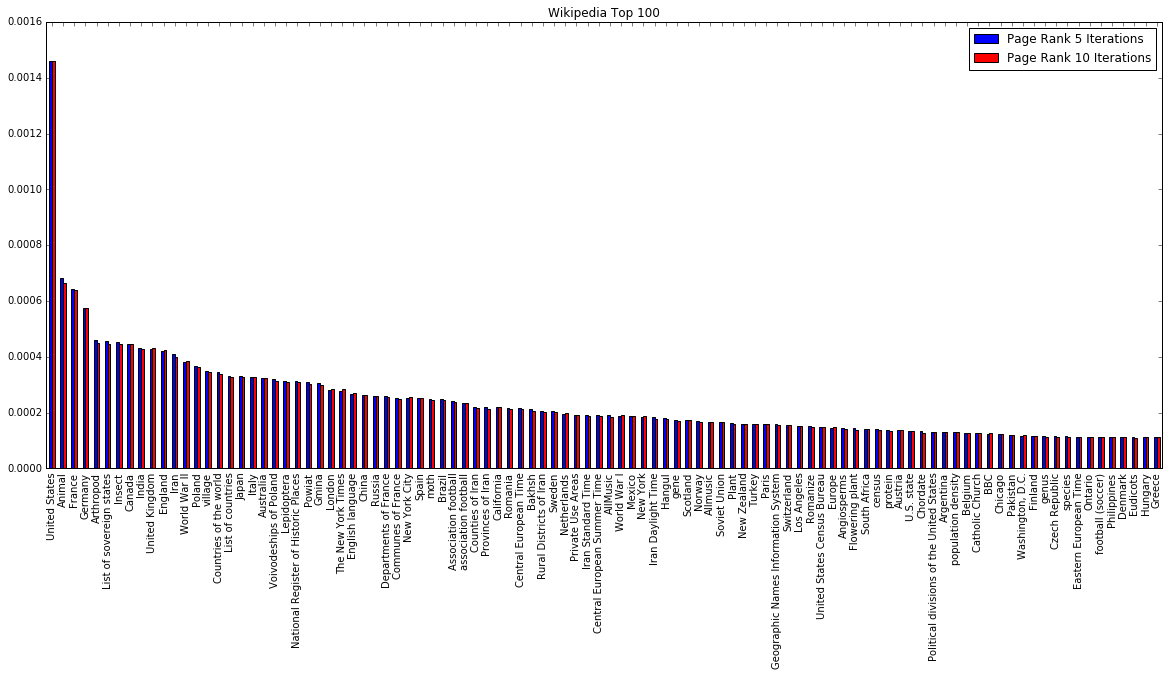

In [6]:
##### OUTPUT FOR HW9.3 TOP 100 PLOTS #####
%matplotlib inline

import pandas

# Initialize a dictionary to store the top100
top100_iter5 = {}
with open('PageRankJoinTop100_iter5.txt', 'r') as f:
    for line in f.readlines():
        index, page_rank, article_name = line.strip().split('\t')
        top100_iter5[article_name] = float(page_rank)
#print len(top100_iter5)
#print top100_iter5

top100_iter10 = {}
with open('PageRankJoinTop100_iter10.txt', 'r') as f:
    for line in f.readlines():
        index, page_rank, article_name = line.strip().split('\t')
        top100_iter10[article_name] = float(page_rank)

#http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html

df = pandas.DataFrame.from_dict(top100_iter5, orient='index')
df.columns = ['Page Rank 5 Iterations']
df = df.sort_index(by='Page Rank 5 Iterations', ascending=False)
df_10 = pandas.DataFrame.from_dict(top100_iter10, orient='index')
df_10.columns = ['Page Rank 10 Iterations']
df = pandas.merge(left=df, right=df_10, left_index = True, right_index = True, how='left')
df.plot(kind='bar', figsize=(20,8), legend=True, title='Wikipedia Top 100', color=['b', 'r'])

In [44]:

!hdfs dfs -cat /user/hadoop/HW9Results/PageRankSort_iter10/part-00000 | grep 4320007
#!hdfs dfs -cat /user/hadoop/HW9Results/PageRank/part-00000 | grep 15070394

16/07/17 10:16:05 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
4320007	0.000110569823502
2749128	3.44743200072e-07
7279307	4.71804320007e-08
14320007	3.85800584089e-08
11546567	3.64320007669e-08


<h2 style="color:darkblue"> HW 9.4: Topic-specific PageRank implementation using MRJob </h2>

Modify your PageRank implementation to produce a topic specific PageRank implementation, as described in:

http://www-cs-students.stanford.edu/~taherh/papers/topic-sensitive-pagerank.pdf

Note in this article that there is a special caveat to ensure that the transition matrix is irreducible.   
This caveat lies in footnote 3 on page 3:
```
	A minor caveat: to ensure that M is irreducible when p
	contains any 0 entries, nodes not reachable from nonzero
	nodes in p should be removed. In practice this is not problematic.
```
and must be adhered to for convergence to be guaranteed.   

Run topic specific PageRank on the following randomly generated network of 100 nodes:

> s3://ucb-mids-mls-networks/randNet.txt (also available on Dropbox)

which are organized into ten topics, as described in the file:

> s3://ucb-mids-mls-networks/randNet_topics.txt  (also available on Dropbox)

Since there are 10 topics, your result should be 11 PageRank vectors (one for the vanilla PageRank implementation in 9.1, and one for each topic with the topic specific implementation). Print out the top ten ranking nodes and their topics for each of the 11 versions, and comment on your result. Assume a teleportation factor of 0.15 in all your analyses.

One final and important comment here:  please consider the requirements for irreducibility with topic-specific PageRank. In particular, the literature ensures irreducibility by requiring that nodes not reachable from in-topic nodes be removed from the network.

This is not a small task, especially as it it must be performed separately for each of the (10) topics.

So, instead of using this method for irreducibility, please comment on why the literature's method is difficult to implement, and what what extra computation it will require.   

Then for your code, please use the alternative, non-uniform damping vector:

```
vji = beta*(1/|Tj|); if node i lies in topic Tj

vji = (1-beta)*(1/(N - |Tj|)); if node i lies outside of topic Tj
```
for beta in (0,1) close to 1. 

With this approach, you will not have to delete any nodes. If beta > 0.5, PageRank is topic-sensitive, and if beta < 0.5, the PageRank is anti-topic-sensitive. For any value of beta irreducibility should hold, so please try beta=0.99, and perhaps some other values locally, on the smaller networks.

<h2 style="color:darkgreen"> HW 9.4 Implementation </h2>

In [3]:
%%writefile PageRankTopicStep2.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import json

# This class takes in the list of nodes mapped to their topic, damping_factor, total_nodes in the graph,
# dangling mass, beta, topic being calculated and the number of nodes in the topic being calculated and
# outputs the topic specific page rank for all nodes in the graph.
class MRPageRankTopicStep2(MRJob):
    def configure_options(self):
        # Configure required command line options
        super(MRPageRankTopicStep2, self).configure_options()
        self.add_passthrough_option('--damping_factor', type='float', default=0.15)
        self.add_passthrough_option('--total_nodes', type='float', default=1.0)
        self.add_passthrough_option('--dangling_mass', type='float', default=0.0)
        self.add_passthrough_option('--beta', type='float', default=0.99)
        self.add_passthrough_option('--topic', type='str', default='')
        self.add_passthrough_option('--topic_size', type='int', default=1)

    def __init__(self, *args, **kwargs):
        super(MRPageRankTopicStep2, self).__init__(*args, **kwargs)
        # Store the node names and their topics in memory
        self.topic_list = {}
        with open('randNet_topics.txt', 'r') as f:
            for line in f.readlines():
                node, topic = line.strip().split('\t')
                self.topic_list[node] = topic

    # Map over each node and calculate its final page rank depending on which topic it
    # belongs to
    def mapper(self, key, line):
        node_num, data = line.strip().split('\t')
        node_num = node_num.strip('"')
        #print node_num, data
        if node_num != '*total_nodes':
            data = json.loads(data)
            adj_dict = data[0]
            page_rank = data[1]
            # If there is no topic, use the non-topic specific page rank calculation
            if self.options.topic == 'Vanilla':
                f_page_rank = (1-self.options.damping_factor)*(1.0/self.options.total_nodes)+ \
                    self.options.damping_factor*((self.options.dangling_mass/self.options.total_nodes)+page_rank)
            # If the node is in the topic that is being calculated, then bias the teleport matrix using 
            # the total_nodes_in_topic
            elif self.topic_list[node_num] == self.options.topic:
                teleport = (self.options.beta/self.options.topic_size)
                f_page_rank = (1-self.options.damping_factor)*teleport+ \
                    self.options.damping_factor*((self.options.dangling_mass/self.options.total_nodes)+page_rank)
            # If the node is NOT in the topic that is being calculated, then bias the teleport matrix using 
            # the (total_nodes - total_nodes_in_topic)
            else:
                teleport = (1-self.options.beta)*(1/(self.options.total_nodes-self.options.topic_size))
                f_page_rank = (1-self.options.damping_factor)*teleport+ \
                    self.options.damping_factor*((self.options.dangling_mass/self.options.total_nodes)+page_rank)
            #print node_num, tuple((adj_dict, f_page_rank))                    
            yield node_num, tuple((adj_dict, f_page_rank))
    
    # Only a mapper is needed here
    def steps(self):
        return [
            MRStep(mapper=self.mapper)
               ]
            
if __name__ == '__main__':
    MRPageRankTopicStep2.run()

Overwriting PageRankTopicStep2.py


In [4]:
# This function prints the contents of filename to a table sorted by page rank.
def print_table(filename, topic_name):
    # Import tabulate to create a table
    from tabulate import tabulate
    from operator import itemgetter

    # Create a variable 'headers' to store the headers of the table
    headers = ['Node Name', 'Topic', 'Page Rank']
    # Initialize a list called data to hold the data for the rows of the table
    data = []
    with open(filename, 'r') as f:
        for line in f.readlines():
            node_num, topic, data_list = line.strip().split('\t')
            node_num = node_num.strip('"')
            data_list = json.loads(data_list)
            page_rank = data_list[1]
            data.append([node_num, topic, str(page_rank)])
    
    # Sort the data by page ranks
    data = sorted(data, key=itemgetter(2), reverse=True)

    # Print the table
    print('Top 10 Page Ranks - Topic %s' % (topic_name))
    # Only print the top 10 results
    print(tabulate(data[:10], headers=headers))
    print('')

In [5]:
import PageRankStep1
import PageRankTopicStep2
import PageRankInit
reload(PageRankStep1)
reload(PageRankTopicStep2)
reload(PageRankInit)
import json

# Set the damping factor, beta and number of iterations
damping_factor = 0.85
beta = 0.99
iterations = 10
num_converter = 10000000000

# Set the names of the files that gets passed from iteration to iteration
work_filename = 'work_table.txt'
work_filename_1 = 'work_table_1.txt'
work_filename_2 = 'work_table_2.txt'

# Call the PageRankInit MRJob and calculate total_nodes
mr_job = PageRankInit.MRPageRankInit(args=['randNet.txt', '--platform', 'local'])
with mr_job.make_runner() as runner, open(work_filename, 'w') as f: 
    runner.run()
    # stream_output: get access of the output 
    for line in runner.stream_output():
        key, value =  mr_job.parse_output_line(line)
        # Store the total_nodes
        if key == '*total_nodes':
            total_nodes = float(value)
        f.write(key+'\t'+json.dumps(value)+'\n')
#print 'total nodes', total_nodes

# Create a list of topic names and their sizes (number of nodes in the topic)
topics = [['Vanilla',100], ['1',17], ['2',8], ['3',9], ['4',13], ['5',9], ['6',6], ['7',10], ['8',9], ['9',7], ['10',12]]
# For each topic, calculate the topic specific page rank
for [topic, topic_size] in topics:
    i = 0
    while(i < iterations):
        # Run the PageRankStep1 MRJob
        mr_job = PageRankStep1.MRPageRankStep1(args=[work_filename, '--num_converter', str(num_converter)])
        with mr_job.make_runner() as runner, open(work_filename_1, 'w') as f: 
            runner.run()
            # stream_output: get access of the output 
            for line in runner.stream_output():
                key, value =  mr_job.parse_output_line(line)
                f.write(key+'\t'+json.dumps(value)+'\n')
        dangling_mass = runner.counters()[0]['PageRank_Counters']['Dangling_Mass']/float(num_converter)

        # Run the PageRankStep2 MRJob
        mr_job = PageRankTopicStep2.MRPageRankTopicStep2(args=[work_filename_1, '--file=randNet_topics.txt', 
                                                               '--damping_factor', damping_factor, '--total_nodes', 
                                                               total_nodes, '--dangling_mass', dangling_mass, 
                                                               '--beta', beta, '--topic', topic, '--topic_size', 
                                                               str(topic_size)])
        with mr_job.make_runner() as runner, open(work_filename_2, 'w') as f: 
            runner.run()
            # stream_output: get access of the output 
            for line in runner.stream_output():
                key, value =  mr_job.parse_output_line(line)
                f.write(key+'\t'+json.dumps(value)+'\n')

        !mv $work_filename_2 $work_filename
        i += 1
    # Copy the final file to another file for storage and sort it
    !cp $work_filename $topic'.txt'
    !sort -k1,1n $topic'.txt' > $topic'2.txt' 
    # Join the file with its topic
    !cut -f2 $topic'2.txt' | paste randNet_topics.txt - > 'pageranktopic_'$topic'.txt'
    # Print the results in a table
    print_table('pageranktopic_'+topic+'.txt', topic)

Top 10 Page Ranks - Topic Vanilla
  Node Name    Topic    Page Rank
-----------  -------  -----------
         15        3    0.0163563
         74       10    0.0159692
         63        4    0.0157709
        100        8    0.0153765
         85        7    0.0151785
          9        2    0.0150325
         58        2    0.0148282
         71        2    0.0144909
         61        8    0.014407
         52        1    0.014311

Top 10 Page Ranks - Topic 1
  Node Name    Topic    Page Rank
-----------  -------  -----------
         32        1    0.0206459
         77        1    0.0205476
         52        1    0.0197543
         92        1    0.0195292
         10        1    0.0185655
         27        1    0.0185225
         85        7    0.0178405
         98        1    0.0176924
         46        1    0.0175141
         74       10    0.0160281

Top 10 Page Ranks - Topic 2
  Node Name    Topic    Page Rank
-----------  -------  -----------
         58        2    0.

### END OF HOMEWORK

In [ ]:
i = 0
# Set stop condition to False
Stop = False
while(False):
#while(Stop == False):
#while(i < 40):
    work_table = {}
    # Store the previous page ranks to compare of the stop conditions
    old_page_ranks = page_ranks
    page_ranks = []
    # Print the iteration number
    print('Iteration %d' % (i))
    with mr_job.make_runner() as runner: 
        runner.run()
        # stream_output: get access of the output 
        for line in runner.stream_output():
            key,value =  mr_job.parse_output_line(line)
            #print key, value
            work_table[key] = value
            page_ranks.append(value[1])
        
        # Update work_table for the next iteration
        with open(work_filename, 'w') as f:
            for key, value in work_table.iteritems():
                f.write(key+'\t'+json.dumps(value)+'\n')
        
        # Check the stop critera against the threshold epsilon
        Stop = stop_criterion_reached(old_page_ranks, page_ranks, epsilon)
        #print('Sum of page ranks: %f' % (sum(page_ranks)))
    i += 1

# Print the final results
#print page_ranks
#print('Sum of page ranks: %f' % (sum(page_ranks)))

In [ ]:
def stop_criterion_reached(old_page_ranks, page_ranks, epsilon):
    Stop = False
    total_error = 0.0
    for pr1, pr2 in zip(old_page_ranks, page_ranks):
        total_error += abs(pr1-pr2)
    print 'Total Error: ', total_error
    if total_error < epsilon:
        Stop = True
    return Stop